In [2]:
import pandas as pd
import numpy as np
import matplotlib.pyplot as plt
import seaborn as sns
import textwrap
import warnings

# Ignore warnings
warnings.filterwarnings("ignore")

# **1. Relational Graph**

In [61]:
# Display output data in Table Format:
def create_bordered_table(df, title, max_display_rows=5):
    """
    Create output data in Table Format
    """
    print(f"\n{title}")
    print("=" * 100)

    headers = ['Year'] + [textwrap.fill(str(col), width=20) for col in df.columns]
    col_widths = []
    for header in headers:
        col_widths.append(max(len(line) for line in header.split('\n')))

    # Adjust Data Width
    for i, col in enumerate([''] + df.columns.tolist()):
        if i == 0:  # Year column
            max_data_width = max(len(str(idx)) for idx in df.head().index)
            col_widths[i] = max(col_widths[i], max_data_width, 4)
        else:
            max_data_width = max(len(str(val)) for val in df.head().iloc[:, i-1])
            col_widths[i] = max(col_widths[i], max_data_width, 8)

    col_widths = [w + 2 for w in col_widths]

    top_border = "┌" + "┬".join(["─" * w for w in col_widths]) + "┐"
    print(top_border)

    header_lines = [header.split('\n') for header in headers]
    max_header_lines = max(len(lines) for lines in header_lines)

    for line_num in range(max_header_lines):
        header_row = "│"
        for i, lines in enumerate(header_lines):
            content = lines[line_num] if line_num < len(lines) else ""
            header_row += f" {content.ljust(col_widths[i]-2)} │"
        print(header_row)

    separator = "├" + "┼".join(["─" * w for w in col_widths]) + "┤"
    print(separator)

    for idx, (index, row) in enumerate(df.head(max_display_rows).iterrows()):
        row_data = [str(index)] + [str(x) for x in row]

        wrapped_cells = []
        max_cell_lines = 1
        for cell in row_data:
            wrapped = textwrap.wrap(str(cell), width=min(25, max(col_widths)-2))
            wrapped_cells.append(wrapped)
            max_cell_lines = max(max_cell_lines, len(wrapped))

        for line_num in range(max_cell_lines):
            data_row = "│"
            for i, wrapped in enumerate(wrapped_cells):
                content = wrapped[line_num] if line_num < len(wrapped) else ""
                data_row += f" {content.ljust(col_widths[i]-2)} │"
            print(data_row)

        if idx < len(df.head(max_display_rows)) - 1:
            print(separator)

    bottom_border = "└" + "┴".join(["─" * w for w in col_widths]) + "┘"
    print(bottom_border)

    print(f"Showing first {min(max_display_rows, len(df))} rows")
    print("=" * 100)

# Load Datasets
df_residents_65plus = pd.read_csv('DataGov_Residents_65Plus.csv', index_col='year')
df_nursinghome = pd.read_csv('DataGov_NursingHome_Beds.csv', index_col='year')

# Display Tables
create_bordered_table(df_residents_65plus, "RESIDENT POPULATION AGED 65 YEARS AND OVER IN RESIDENT HOUSEHOLDS BY LIVING ARRANGEMENT")
create_bordered_table(df_nursinghome, "HEALTH FACILITIES AND BEDS IN INPATIENT FACILITIES")



RESIDENT POPULATION AGED 65 YEARS AND OVER IN RESIDENT HOUSEHOLDS BY LIVING ARRANGEMENT
┌──────┬──────────────┬──────────────────────┬─────────────────────┬─────────────────┬──────────────────────┬──────────┬──────────┐
│ Year │ Age Category │ Living With Spouse & │ Living With Spouse, │ Living Alone In │ Living With Children │ Others   │ Total    │
│      │              │ At Least One Child   │ No Children In      │ Household       │ But Without Spouse   │          │          │
│      │              │ In Household         │ Household           │                 │ In Household         │          │          │
├──────┼──────────────┼──────────────────────┼─────────────────────┼─────────────────┼──────────────────────┼──────────┼──────────┤
│ 2024 │ Sub-Total    │ 271800               │ 208600              │ 87200           │ 132000               │ 68400    │ 767900   │
├──────┼──────────────┼──────────────────────┼─────────────────────┼─────────────────┼──────────────────────┼──────────

In [63]:
# Prepare Residents Data
df_residents = df_residents_65plus.reset_index()[['year', 'Total']].copy()
df_residents['Total'] = pd.to_numeric(df_residents['Total'], errors='coerce')

# Group using "year"
df_residents = df_residents.groupby('year', as_index=False)['Total'].sum()
df_residents = df_residents.rename(columns={'Total': 'Residents65Plus'})

# Prepare Nursing Home Data and Sum the Total Number of Bed using "Year"
df_nursinghome_beds = df_nursinghome.reset_index().groupby('year', as_index=False)['no_beds'].sum()
df_nursinghome_beds = df_nursinghome_beds.rename(columns={'no_beds': 'NursingHomeBeds'})

# Merge the 2 Datasets using "year"
df_merge = pd.merge(df_residents, df_nursinghome_beds, on='year', how='inner')

In [64]:
# Relational Graph (Scatter Plot with Regression Line)

# Define plotting function
def plot_relational(df):
    """
    Scatter + regression line showing how the number of nursing home beds relates to
    number of elderly residents (65+).
    """
    plt.figure(dpi=144)
    sns.scatterplot(data=df, x="Residents65Plus", y="NursingHomeBeds", s=100)
    sns.regplot(data=df, x="Residents65Plus", y="NursingHomeBeds", scatter=False, color="red")

    for _, row in df.iterrows():
        plt.text(row["Residents65Plus"], row["NursingHomeBeds"], str(row["year"]),
                 fontsize=8, ha='right', va='bottom')

    # Add Title and Labels
    plt.title("Relation: Elderly Residents Aged 65years and Over vs Nursing Home Beds (Singapore)")
    plt.xlabel("Number of Residents Aged 65years and Over")
    plt.ylabel("Number of Nursing Home Beds")
    plt.tight_layout()

    # Show the Plot
    plt.show()

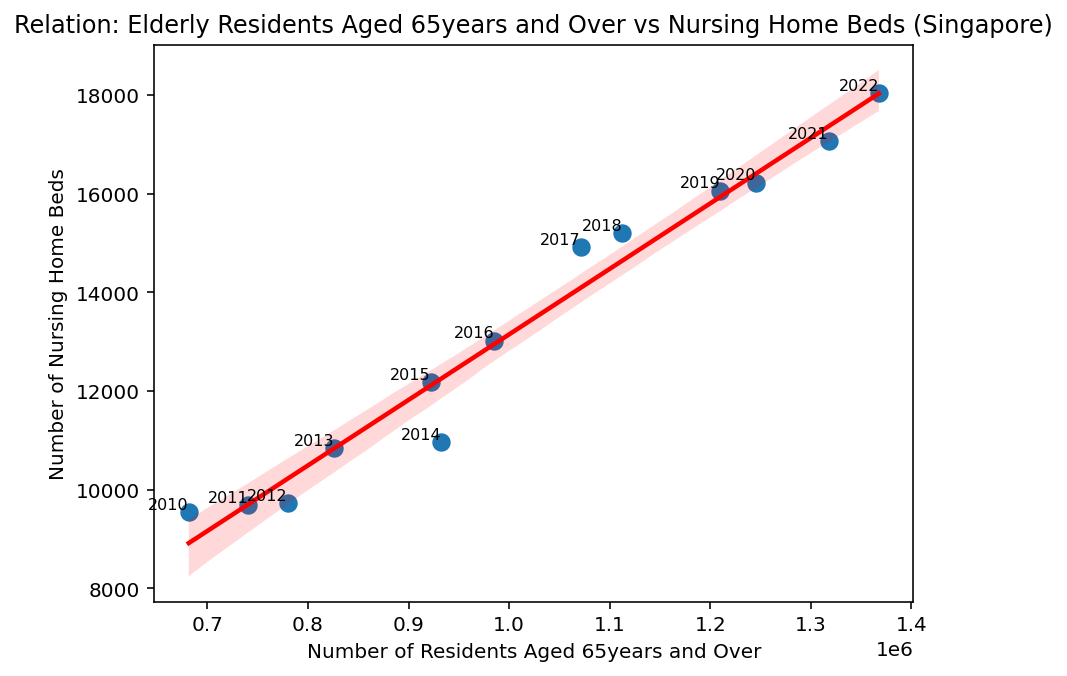

MERGED DATASET FOR PLOTTING

RESIDENT POPULATION AGED 65 YEARS AND OVER vs NURSING HOME BEDS
┌──────┬──────────┬─────────────────┬─────────────────┐
│ Year │ year     │ Residents65Plus │ NursingHomeBeds │
├──────┼──────────┼─────────────────┼─────────────────┤
│ 0    │ 2010     │ 681500          │ 9551            │
├──────┼──────────┼─────────────────┼─────────────────┤
│ 1    │ 2011     │ 740600          │ 9690            │
├──────┼──────────┼─────────────────┼─────────────────┤
│ 2    │ 2012     │ 779700          │ 9721            │
├──────┼──────────┼─────────────────┼─────────────────┤
│ 3    │ 2013     │ 826200          │ 10838           │
├──────┼──────────┼─────────────────┼─────────────────┤
│ 4    │ 2014     │ 932700          │ 10968           │
├──────┼──────────┼─────────────────┼─────────────────┤
│ 5    │ 2015     │ 921900          │ 12185           │
├──────┼──────────┼─────────────────┼─────────────────┤
│ 6    │ 2016     │ 985400          │ 13022           │
├──────┼───

In [6]:
# General correlation between elderly residents (65+) and available nursing home beds.
# Call the plotting function
plot_relational(df_merge)

# Display the merged dataset for verification
print("MERGED DATASET FOR PLOTTING")

# Output data in formatted tables with:
# Clear borders around each cell
# Wrapped text for long headers and values
# Left-aligned content

def create_bordered_table(df, title):
    """
    Create a bordered table with text wrapping and left alignment
    """
    print(f"\n{title}")
    print("=" * 100)

    # Prepare headers
    headers = ['Year'] + [textwrap.fill(str(col), width=20) for col in df.columns]

    # Calculate column widths
    col_widths = []
    for header in headers:
        col_widths.append(max(len(line) for line in header.split('\n')))

    # Adjust based on data
    for i, col in enumerate([''] + df.columns.tolist()):
        if i == 0:  # Year column
            max_data_width = max(len(str(idx)) for idx in df.head().index)
            col_widths[i] = max(col_widths[i], max_data_width, 4)
        else:
            max_data_width = max(len(str(val)) for val in df.head().iloc[:, i-1])
            col_widths[i] = max(col_widths[i], max_data_width, 8)

    # Add padding
    col_widths = [w + 2 for w in col_widths]

    # Create top border
    top_border = "┌" + "┬".join(["─" * w for w in col_widths]) + "┐"
    print(top_border)

    # Print header
    header_lines = [header.split('\n') for header in headers]
    max_header_lines = max(len(lines) for lines in header_lines)

    for line_num in range(max_header_lines):
        header_row = "│"
        for i, lines in enumerate(header_lines):
            content = lines[line_num] if line_num < len(lines) else ""
            header_row += f" {content.ljust(col_widths[i]-2)} │"
        print(header_row)

    # Print header-data separator
    separator = "├" + "┼".join(["─" * w for w in col_widths]) + "┤"
    print(separator)

    # Print data rows
    for idx, (index, row) in enumerate(df.iterrows()):
        row_data = [str(index)] + [str(x) for x in row]

        # Wrap each cell
        wrapped_cells = []
        max_cell_lines = 1
        for cell in row_data:
            wrapped = textwrap.wrap(str(cell), width=min(25, max(col_widths)-2))
            wrapped_cells.append(wrapped)
            max_cell_lines = max(max_cell_lines, len(wrapped))

        # Print each line of wrapped cells
        for line_num in range(max_cell_lines):
            data_row = "│"
            for i, wrapped in enumerate(wrapped_cells):
                content = wrapped[line_num] if line_num < len(wrapped) else ""
                data_row += f" {content.ljust(col_widths[i]-2)} │"
            print(data_row)

        # Print row separator (except for last row)
        if idx < len(df) - 1:
            print(separator)

    # Print bottom border
    bottom_border = "└" + "┴".join(["─" * w for w in col_widths]) + "┘"
    print(bottom_border)

# Display tables with borders
create_bordered_table(df_merge, "RESIDENT POPULATION AGED 65 YEARS AND OVER vs NURSING HOME BEDS")

# **2. Categorical Graph**

In [65]:
# Load Datasets
df_health_facilities = pd.read_csv('DataGov_Health Facilities_Public.csv', index_col='year')

# Print Dataframe
print("Health Facilites Data:")
print(df_health_facilities.head())

Health Facilites Data:
     institution_type facility_type_a  public_private  no_of_facilities  \
year                                                                      
2009         Hospital           Acute          Public                 7   
2009         Hospital           Acute  Not-for-Profit                 1   
2009         Hospital           Acute         Private                 6   
2010         Hospital           Acute          Public                 8   
2010         Hospital           Acute  Not-for-Profit                 1   

      no_beds  
year           
2009     6416  
2009      303  
2009     1570  
2010     6871  
2010      283  


In [66]:
print("Preview of Dataset")
print(df_residents)

Preview of Dataset
    year  Residents65Plus
0   2010           681500
1   2011           740600
2   2012           779700
3   2013           826200
4   2014           932700
5   2015           921900
6   2016           985400
7   2017          1071200
8   2018          1112600
9   2019          1210000
10  2020          1245900
11  2021          1317800
12  2022          1367600
13  2023          1417300
14  2024          1535800


In [68]:
# Data Preparation
cols_to_convert = [
    'Living With Spouse & At Least One Child In Household',
    'Living With Spouse, No Children In Household',
    'Living Alone In Household',
    'Living With Children But Without Spouse In Household',
    'Others',
    'Total'
]
df_residents_65plus[cols_to_convert] = df_residents_65plus[cols_to_convert].apply(pd.to_numeric, errors='coerce')
df_subtotal = df_residents_65plus[df_residents_65plus['Age Category'] == 'Sub-Total'].copy()
df_subtotal = df_subtotal.reset_index()
df_melted = df_subtotal.melt(
    id_vars=['year'],
    value_vars=[
        'Living With Spouse & At Least One Child In Household',
        'Living With Spouse, No Children In Household',
        'Living Alone In Household',
        'Living With Children But Without Spouse In Household',
        'Others'
    ],
    var_name='Living_Arrangement',
    value_name='Number_of_Residents'
)

In [69]:
print("Data for Categorical Graph")
print(df_melted)

Data for Categorical Graph
    year                                 Living_Arrangement  \
0   2024  Living With Spouse & At Least One Child In Hou...   
1   2023  Living With Spouse & At Least One Child In Hou...   
2   2022  Living With Spouse & At Least One Child In Hou...   
3   2021  Living With Spouse & At Least One Child In Hou...   
4   2020  Living With Spouse & At Least One Child In Hou...   
..   ...                                                ...   
70  2014                                             Others   
71  2013                                             Others   
72  2012                                             Others   
73  2011                                             Others   
74  2010                                             Others   

    Number_of_Residents  
0                271800  
1                243700  
2                255800  
3                221800  
4                214600  
..                  ...  
70                29900  
71      

In [70]:
# Function01 Stacked Bar Chart
def plot_categorical_stacked_bar(df):
    """
    Categorical Graph: Stacked Bar Chart comparing living arrangements of elderly residents by year.
    """
    df_pivot = df.pivot(index='year', columns='Living_Arrangement', values='Number_of_Residents')
    df_pivot = df_pivot.sort_index()

    # Plot stacked bar chart
    ax = df_pivot.plot(
        kind='bar',
        stacked=True,
        figsize=(12, 6),
        colormap='tab20',
        edgecolor='black'
    )

    plt.title("Stacked Bar Chart: Living Arrangements of Residents Aged 65 Years and Over by Year")
    plt.xlabel("Year")
    plt.ylabel("Number of Residents")
    plt.legend(title='Living Arrangement', bbox_to_anchor=(1.05, 1), loc='upper left')
    plt.tight_layout()
    plt.show()

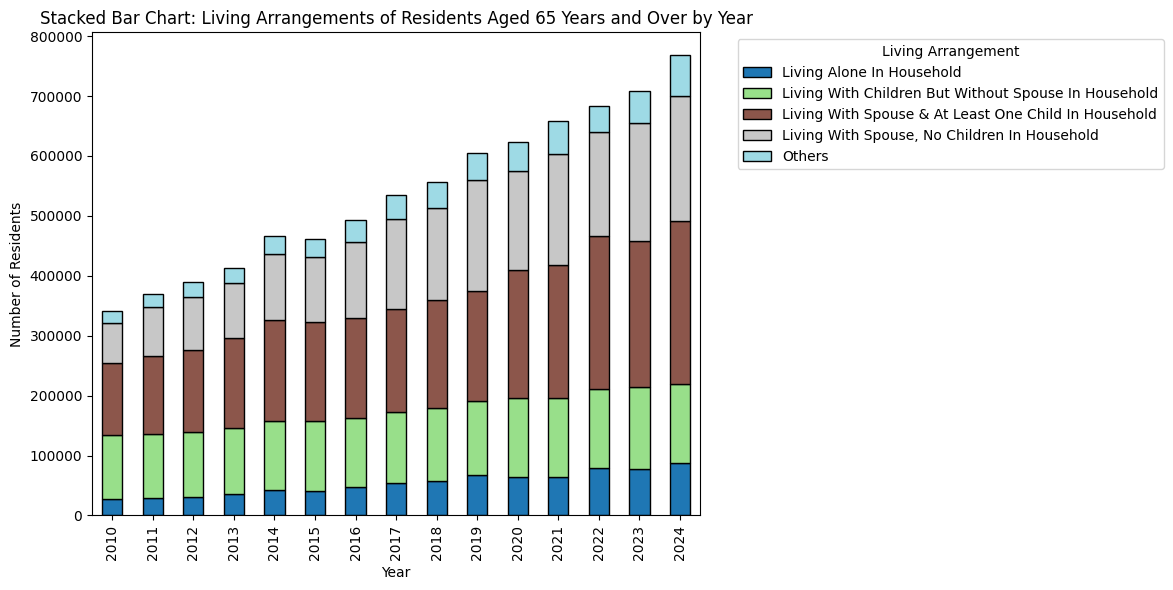

In [12]:
# Call the Functions
plot_categorical_stacked_bar(df_melted)

In [59]:
# Set style for better looking plots
plt.style.use('seaborn-v0_8')
sns.set_palette("husl")

# **3. Statistical Graph**

In [31]:
# Load the datasets
df_healthy_life = pd.read_csv('WHO_SG_Healthy Life Expectancy at Birth.csv')
df_life_expectancy = pd.read_csv('WHO_SG_Life Expectancy at Birth.csv')
df_death_causes = pd.read_csv('WHO_SG_Top Causes of Death.csv')


In [71]:
# Data Preparation Functions
def prepare_life_expectancy_data(df_healthy, df_life):
    """Prepare and merge healthy life expectancy and total life expectancy data"""
    # Filter data
    healthy_clean = df_healthy[['DIM_TIME', 'DIM_SEX', 'AMOUNT_N']].copy()
    life_clean = df_life[['DIM_TIME', 'DIM_SEX', 'AMOUNT_N']].copy()

    healthy_clean.columns = ['Year', 'Sex', 'Healthy_Life_Expectancy']
    life_clean.columns = ['Year', 'Sex', 'Total_Life_Expectancy']
    merged_df = pd.merge(healthy_clean, life_clean, on=['Year', 'Sex'])
    merged_df['Unhealthy_Years'] = merged_df['Total_Life_Expectancy'] - merged_df['Healthy_Life_Expectancy']

    return merged_df


In [33]:
# Data Preparation Functions
def prepare_death_causes_data(df):
    """Prepare death causes data for analysis"""
    # Filter out zero values and sort by death rate
    df_filtered = df[df['VAL_DTHS_RATE100K_NUMERIC'] > 0].copy()
    df_sorted = df_filtered.sort_values('VAL_DTHS_RATE100K_NUMERIC', ascending=False)

    return df_sorted

In [34]:
 # Prepare data
 df_life_merged = prepare_life_expectancy_data(df_healthy_life, df_life_expectancy)
 df_death_causes_clean = prepare_death_causes_data(df_death_causes)

In [35]:
# Plotting Functions
def plot_life_expectancy_trends(df):
    """Line chart showing life expectancy trends by gender over time"""
    plt.figure(figsize=(12, 8))

    for sex in df['Sex'].unique():
        df_sex = df[df['Sex'] == sex]
        plt.plot(df_sex['Year'], df_sex['Total_Life_Expectancy'],
                marker='o', linewidth=2, label=f'Total Life Expectancy - {sex}')
        plt.plot(df_sex['Year'], df_sex['Healthy_Life_Expectancy'],
                marker='s', linewidth=2, linestyle='--', label=f'Healthy Life Expectancy - {sex}')

    plt.title('Life Expectancy Trends in Singapore (2000-2021)', fontsize=14, fontweight='bold')
    plt.xlabel('Year', fontsize=12)
    plt.ylabel('Life Expectancy (Years)', fontsize=12)
    plt.legend(bbox_to_anchor=(1.05, 1), loc='upper left')
    plt.grid(True, alpha=0.3)
    plt.xticks(rotation=45)
    plt.tight_layout()
    plt.show()


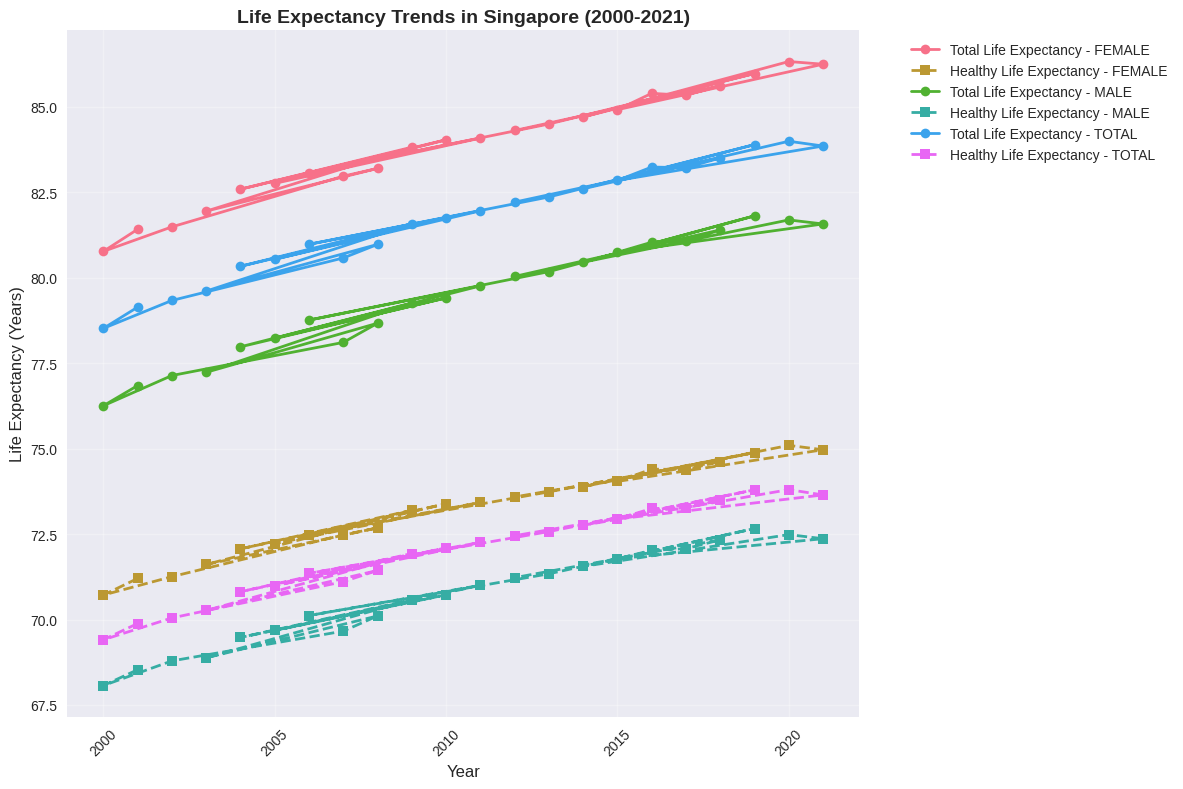

In [60]:
 # Generate plots
 plot_life_expectancy_trends(df_life_merged)